# Movie Recommende system

In [ ]:
# Recommender System Types:
# Recommender systems can be loosely broken down into three categories: 
# content based systems, 
# collaborative filtering systems, 
# hybrid systems (which use a combination of the other two).

In [ ]:
#---------------------#
# Available approach
#--------------------#

# Content based approach utilizes a series of discrete characteristics of an 
# item in order to recommend additional items with similar properties.

# Collaborative filtering approach builds a model from a user’s past behaviors 
# (items previously purchased or selected and/or numerical ratings given to those items) 
# as well as similar decisions made by other users. This model is then used to 
# predict items (or ratings for items) that the user may have an interest in.

# Hybrid approach combines the previous two approaches. Most businesses probably 
# use hybrid approach in their production recommender systems.

##### Loading necessary libraries and datasetary libraries and dataset

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from IPython.display import Image
# utils import
from fuzzywuzzy import fuzz

In [3]:
# read data
df_movies = pd.read_csv(
    'http://khansingh.xyz/Datasets/movies.csv',
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    'http://khansingh.xyz/Datasets/ratings.csv',
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [4]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
df_movies.count()

movieId    9742
title      9742
dtype: int64

In [6]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
df_ratings[df_ratings['movieId']==2][0:5]

,userId,movieId,rating
560,6,2,4.0
1026,8,2,4.0
1773,18,2,3.0
2275,19,2,3.0
2977,20,2,3.0


In [8]:
print(df_movies.shape)
print(df_ratings.shape)

(9742, 2)
(100836, 3)


In [9]:
df_complete = pd.merge(df_ratings, df_movies, on='movieId')
df_complete.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [11]:
df_complete.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Sorority House Massacre (1986)                   5.0
Bill Hicks: Revelations (1993)                   5.0
My Man Godfrey (1957)                            5.0
Hellbenders (2012)                               5.0
In the blue sea, in the white foam. (1984)       5.0
Name: rating, dtype: float32

In [ ]:
df_complete.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

# Creating a ratings dataframe with average rating and number of ratings

In [14]:
ratings = pd.DataFrame(df_complete.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [15]:
ratings['title_freq'] = pd.DataFrame(df_complete.groupby('title')['rating'].count())
ratings.head()

,rating,title_freq
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


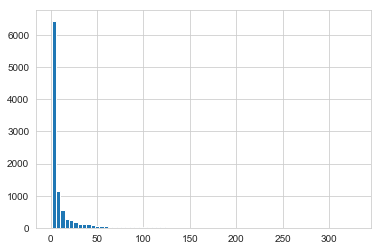

In [16]:
ratings['title_freq'].hist(bins=70)

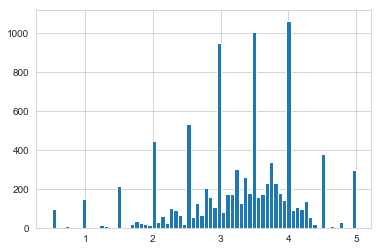

In [17]:
ratings['rating'].hist(bins=70)

In [18]:
sns.set_style('whitegrid')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


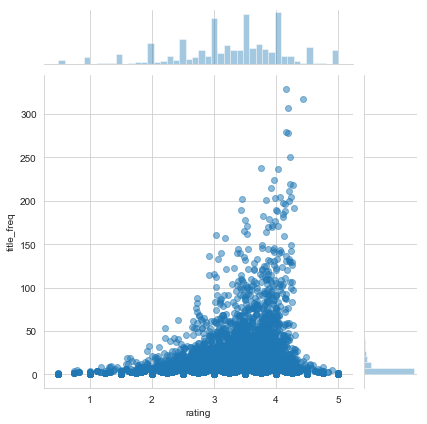

In [19]:
sns.jointplot(x='rating', y='title_freq', data=ratings, alpha=0.5)

In [ ]:
# We will use kNN to build collaborative filtering
# KNN does not make any assumptions on the underlying data distribution but it 
# relies on item feature similarity. When KNN makes inference about a movie, 
# KNN will calculate the “distance” between the target movie and every other movie 
# in its database, then it ranks its distances and returns the top K nearest neighbor 
# movies as the most similar movie recommendations.

In [21]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[df_movie_features.index].title))
}

# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)



In [22]:
df_movie_features.head(5)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_movie_features_name = df_complete.pivot_table(
    index='userId',
    columns='title',
    values='rating'
).fillna(0)

In [27]:
df_movie_features_name.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
ratings.sort_values('title_freq', ascending=False).head(10)


,rating,title_freq
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


In [29]:
mat_movie_features

<9724x610 sparse matrix of type '<class 'numpy.float32'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [30]:
df_movie_cnt = pd.DataFrame(df_complete.groupby('movieId').size(), columns=['movie_cnt'])
df_movie_cnt.head()

,movie_cnt
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

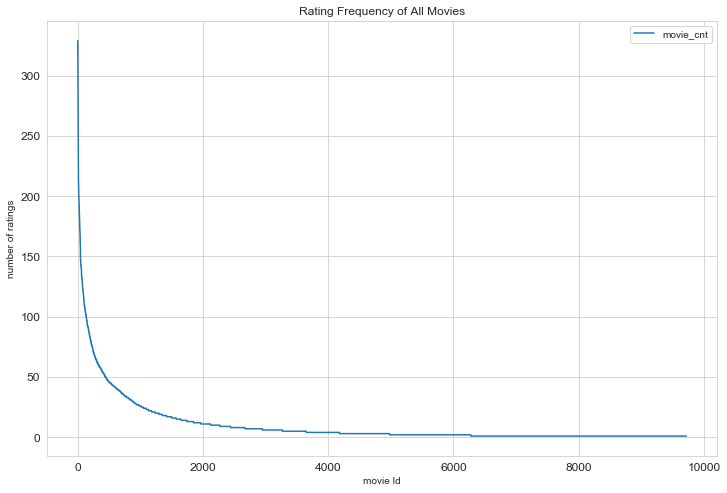

In [31]:
ax = df_movie_cnt \
    .sort_values('movie_cnt', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

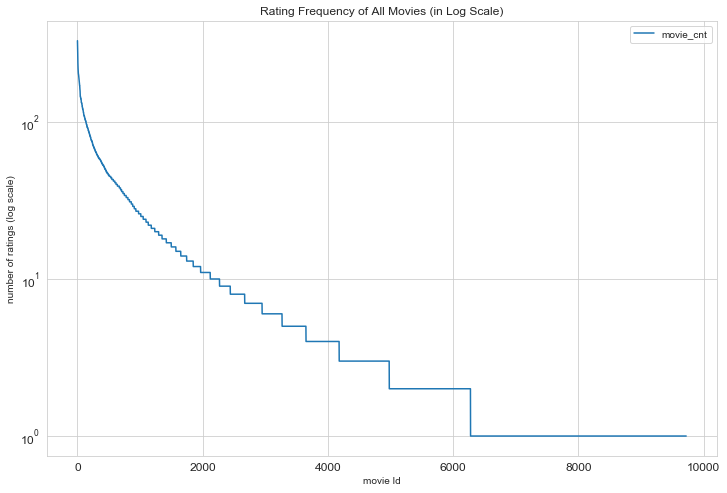

In [32]:
# plot the same distribution but with log scale

ax = df_movie_cnt \
    .sort_values('movie_cnt', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [33]:
df_movie_cnt['movie_cnt'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: movie_cnt, dtype: float64

In [34]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movie_cnt.query('movie_cnt >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (41360, 3)


In [35]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['movie_cnt'])
df_users_cnt.head()

,movie_cnt
userId,
1,117
2,15
3,6
4,84
5,34


Text(0, 0.5, 'number of ratings')

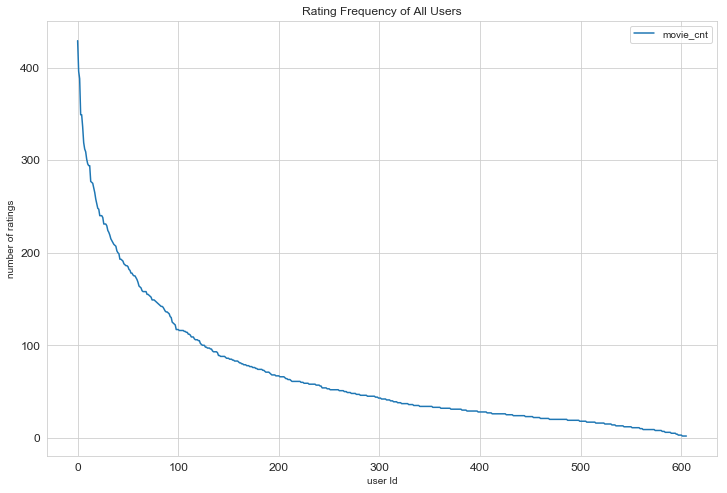

In [36]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('movie_cnt', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [37]:
df_users_cnt['movie_cnt'].quantile(np.arange(1, 0.5, -0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: movie_cnt, dtype: float64

In [38]:
# As we can see it through the data that vast majority of peple aren't interested in rating a movie so, we could consider top 40%
#of our data.

# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('movie_cnt >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 3)


In [39]:
df_movie_features.shape

(9724, 610)

In [ ]:
# Notice that we have got a pretty high dimensional dataset to deal with
# While it was required to do what we did, but high dimensionality is not good for kNN
# Also, Euclidean distance is unhelpful in high dimensions because all vectors 
# are almost equidistant to the search query vector (target movie’s features). 
# Instead, we will use cosine similarity for nearest neighbor search.

# The cosine similarity is advantageous because even if the two similar vectors or
# documents are far apart by the Euclidean distance (due to the size of the document), 
# chances are they may still be oriented closer together. 
# The smaller the angle, higher the cosine similarity.

# When plotted on a multi-dimensional space, where each dimension corresponds to a feature 
# in the feature vector, the cosine similarity captures the orientation (the angle) of the 
# feature and not the magnitude. If you want the magnitude, compute the Euclidean distance instead.

# There is also another popular approach to handle nearest neighbor search in 
# high dimensional data, locality sensitive hashing

In [40]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [41]:
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [42]:
distances, indices = model_knn.kneighbors(mat_movie_features)

In [43]:
indices

array([[   0, 2353,  418, ..., 1182,   31,  277],
       [   1,  322,  436, ...,  217,  138,  615],
       [   2, 2578,  607, ...,  619,   71,  363],
       ...,
       [9599, 9439, 9606, ..., 9259, 9155, 9576],
       [9599, 9439, 9606, ..., 9259, 9155, 9576],
       [9723, 9665, 9603, ..., 8448, 7876, 6805]], dtype=int64)

In [44]:
indices[0]

array([   0, 2353,  418,  615,  224,  314,  322,  910,  546,  963,  968,
       3189,  506,  123,  257,  897,  815, 1182,   31,  277], dtype=int64)

In [45]:
distances

array([[0.0000000e+00, 4.2739868e-01, 4.3436319e-01, ..., 4.9068290e-01,
        4.9140745e-01, 4.9145526e-01],
       [1.1920929e-07, 4.1156250e-01, 4.5018190e-01, ..., 5.3085786e-01,
        5.3686357e-01, 5.3735548e-01],
       [4.1723251e-07, 5.5201328e-01, 5.5321550e-01, ..., 6.1204201e-01,
        6.1350977e-01, 6.1709690e-01],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.1403463e-01, 7.0749104e-01, ..., 8.0346769e-01,
        8.0870879e-01, 8.0925328e-01]], dtype=float32)

In [46]:
distances[0]

array([0.        , 0.42739868, 0.4343632 , 0.4357382 , 0.44261175,
       0.452904  , 0.4588548 , 0.4589107 , 0.46108717, 0.46583116,
       0.4696188 , 0.47202337, 0.47214073, 0.4796753 , 0.48196733,
       0.48581868, 0.48775423, 0.4906829 , 0.49140745, 0.49145526],
      dtype=float32)

In [47]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [48]:
my_favorite = 'Pulp Fiction (1994)'

make_recommendation(
    model_knn=model_knn,
    data=mat_movie_features,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Pulp Fiction (1994)
Found possible matches in our database: ['Pulp Fiction (1994)', 'Suspicion (1941)', 'Affliction (1997)', 'Election (1999)', 'Class Action (1991)', 'Cruel Intentions (1999)', 'Purple Rain (1984)', 'Flirting (1991)', 'Our Town (1940)', 'Pushing Tin (1999)', 'Blink (1994)', 'Pumping Iron (1977)', 'Repulsion (1965)', 'Chill Factor (1999)', 'Civil Action, A (1998)', 'Soul Food (1997)', 'Multiplicity (1996)', 'Pinocchio (1940)', '8 Seconds (1994)', 'Little Women (1994)', 'Drop Zone (1994)', 'Mute Witness (1994)', 'Nico Icon (1995)', 'Double Dragon (1994)', 'Leap of Faith (1992)', 'PCU (1994)', 'Little Giants (1994)', 'Last Seduction, The (1994)', 'Fun (1994)', 'Double Impact (1991)', 'Paulie (1998)', 'U Turn (1997)', 'Last Action Hero (1993)', 'Priest (1994)', 'Junior (1994)', 'Lilting (2014)', 'Chaplin (1992)', 'Thumbelina (1994)', 'Sugar Town (1999)', 'Platoon (1986)', 'Go Fish (1994)', 'Blue Chips (1994)', 'Timecop (1994)', 'Paper, The (1994)', 'M

In [49]:
# checking how sparse the movie-user matrix is by calculating percentage of zero values in the data.

# calcuate total number of entries in the movie-user matrix
num_entries = df_movie_features.shape[0] * df_movie_features.shape[1]
# calculate total number of entries with zero values
num_zeros = (df_movie_features==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 98.30% of ratings in our data is missing


In [ ]:
# With the existing fitted model, if you ask it to get you top 5 related 
# movies for a given movie, it can give you that. Just find the index of
# a given movie from df_movies, and for the recommended indexes, find their
# corresponding movie names.

# Finding corresponding movie names without using knn

In [51]:
eXistenZ_usr_rating = df_movie_features_name['eXistenZ (1999)']
Jurassic_Park_usr_rating = df_movie_features_name['Jurassic Park (1993)']

In [52]:
eXistenZ_usr_rating.sort_values(ascending=False).head(3)

userId
603    5.0
198    5.0
125    5.0
Name: eXistenZ (1999), dtype: float32

In [53]:
Jurassic_Park_usr_rating.sort_values(ascending=False).head(3)

userId
610    5.0
164    5.0
96     5.0
Name: Jurassic Park (1993), dtype: float32

In [54]:
similar_to_eXistenz = df_movie_features_name.corrwith(eXistenZ_usr_rating)
similar_to_eXistenz.head(5)

title
'71 (2014)                                -0.007675
'Hellboy': The Seeds of Creation (2004)   -0.007675
'Round Midnight (1986)                    -0.010863
'Salem's Lot (2004)                       -0.007675
'Til There Was You (1997)                 -0.010538
dtype: float64

In [55]:
similar_to_Jurassic_Park = df_movie_features_name.corrwith(Jurassic_Park_usr_rating)
similar_to_Jurassic_Park.head(5)

title
'71 (2014)                                 0.075222
'Hellboy': The Seeds of Creation (2004)    0.043320
'Round Midnight (1986)                     0.008636
'Salem's Lot (2004)                       -0.031117
'Til There Was You (1997)                 -0.042724
dtype: float64

In [56]:
corr_eXistenz = pd.DataFrame(similar_to_eXistenz, columns=['Corr_fact'])
corr_eXistenz.dropna(inplace=True)
corr_eXistenz.head(2)

,Corr_fact
title,
'71 (2014),-0.007675
'Hellboy': The Seeds of Creation (2004),-0.007675


# So we just effectively identify there are two shortcomings in item based  collaborative filtering:

   ## 1. popularity bias: recommender is prone to recommender popular items
   ## 2. item cold-start problem: recommender fails to recommend new or less-known 
   ## items because items have either none or very little interactions
   ## imagine for a new movie with no or little ratings

In [57]:
# There are three cases of cold start:

#1. New community: refers to the start-up of the recommender, when, although a catalogue of items might exist, 
#   almost no users are present and the lack of user interaction makes very hard to provide reliable recommendations
#2. New item: a new item is added to the system, it might have some content information but no interactions are present
#3. New user: a new user registers and has not provided any interaction yet, therefore it is not possible 
#to provide personalized recommendations

# Handling cold-start problem

corr_eXistenz_ex = corr_eXistenz.join(ratings['title_freq'], how='left', lsuffix='_left', rsuffix='_right')
corr_eXistenz_ex.head(4)

,Corr_fact,title_freq
title,,
'71 (2014),-0.007675,1
'Hellboy': The Seeds of Creation (2004),-0.007675,1
'Round Midnight (1986),-0.010863,2
'Salem's Lot (2004),-0.007675,1


In [ ]:
# Improvements to the current system #
#================#

# This movie recommender could be further improvised using "Matrix Factorization"

# In a real world setting, the vast majority of movies receive very few or 
# even no ratings at all by users. We are looking at an extremely sparse matrix 
# with more than 99% of entries are missing values. With such a sparse matrix, what 
# ML algorithms can be trained and reliable to make inference? So, data sparcity problem
# has to be addressed to build a better model and Matrix Factorization is THE solution


In [ ]:
#---------------------#
# Matrix Factorization
#--------------------#

# Factorization means decomposing an entity into multiple entries - that can be 
# typically 'managed' more easily. For example, 6 can be decomposed as product 
# of 3 and 2. Extending this idea to matrices, matrix factorization is a method 
# of decomposing matrix into more 'manageable' matrices. Most simplest form can 
# be mathematically written as: R=XYT where R is the MxN matrix which we want to 
# decompose into matrices X (MxK) and Y (NxK) respectively.

In [ ]:
# When a user gives feed back to a certain movie they saw (say they can rate from one to five), 
# this collection of feedback can be represented in a form of a matrix. Where each row 
# represents each users, while each column represents different movies. Obviously the 
# matrix will be sparse since not everyone is going to watch every movies, 
# (we all have different taste when it comes to movies).

# One strength of matrix factorization is the fact that it can incorporate implicit feedback, 
# information that are not directly given but can be derived by analyzing user behavior. 
# Using this strength we can estimate if a user is going to like a movie that (he/she) 
# never saw. And if that estimated rating is high, we can recommend that movie to the user.
